In [1]:
import requests
import pandas as pd
import sys
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import PIL
import cv2
import seaborn as sns

# from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
# from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
# from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.applications.vgg16 import preprocess_input

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
# from sklearn.metrics import confusion_matrix

from tensorflow.keras import activations

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Conv2D, ZeroPadding2D, Flatten, AveragePooling2D, Dense, Activation, Add
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


import SciServer.CasJobs as CasJobs # query with CasJobs, the primary database for the SDSS
import SciServer.SkyServer as SkyServer # show individual objects through SkyServer
import SciServer.SciDrive
import warnings
# warnings.filterwarnings('ignore')


In [42]:
# # Helper functions for visualization:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    From scikit-learn: plots a confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    #fixes "squishing of plot"
    plt.ylim([1.5, -.5])

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

def plot_model_history(history, n_epochs):
    '''Plot the training and validation history for a TensorFlow network'''

    # Extract loss and accuracy
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
    ax[0].plot(np.arange(n_epochs), loss, label='Training Loss')
    ax[0].plot(np.arange(n_epochs), val_loss, label='Validation Loss')
    ax[0].set_title('Loss Curves')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(n_epochs), acc, label='Training Accuracy')
    ax[1].plot(np.arange(n_epochs), val_acc, label='Validation Accuracy')
    ax[1].set_title('Accuracy Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    
    
# # Check balance of labels/data in dataframe

def checkBalance(df):
    all_labels = df['labels']
    all_labels = all_labels.tolist()
    balance = df['labels'].value_counts()
    print(balance)
    for i in range(len(balance)):
        print(f'{balance[i]*200/df.size:.2f} %')

In [3]:
df0 = pd.read_fwf('../PCC_cat.txt', header=None)
# df0[21] # 21 is the label entry index
df0

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,NaN,PCC-0001,49.2355,41.5722,20.51,0.04,1.44,0.10,20.80,1.07,...,0.69,0.25,0.63,0.28,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
1,NaN,PCC-0002,49.2366,41.4013,20.44,0.04,2.18,0.14,21.96,0.79,...,1.53,1.01,1.38,0.97,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
2,NaN,PCC-0003,49.2370,41.4336,21.58,0.04,1.11,0.07,22.41,0.07,...,1.25,0.71,1.19,0.67,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
3,NaN,PCC-0004,49.2377,41.5285,21.03,0.06,1.08,0.10,23.14,0.69,...,0.58,0.25,0.42,0.15,NaN,NaN,Likely background ETG or unresolved source,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
4,NaN,PCC-0005,49.2380,41.4346,20.27,0.02,1.24,0.04,21.94,0.80,...,0.70,0.50,0.53,0.48,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5432,NaN,PCC-5433,50.0062,41.2380,20.32,NaN,1.10,NaN,22.53,3.80,...,0.97,0.83,0.93,0.69,NaN,NaN,Likely background ETG or unresolved source,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
5433,NaN,PCC-5434,50.0064,41.2568,22.63,NaN,0.54,NaN,23.29,0.50,...,1.46,1.12,NaN,NaN,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
5434,NaN,PCC-5435,50.0068,41.6048,21.44,0.02,0.61,0.02,21.52,0.43,...,0.59,0.41,NaN,NaN,NaN,NaN,Likely cluster or background edge-on disk galaxy,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...
5435,NaN,PCC-5436,50.0070,41.3916,21.32,0.07,0.99,0.10,22.86,0.95,...,1.19,1.07,1.06,0.92,NaN,NaN,Cluster or background LTG,NaN,NaN,http://dc.zah.uni-heidelberg.de/pcc/q/stamp/dl...


In [4]:
# # Here we have 7 unique labels:
labels = np.unique(df0[21])

# access ra and dec from their columns in the dataframe
ra = df0[2]
dec = df0[3]

# want only bright objects above r_mag < 19.4  (the magnitude decreases as brightness increases)
bright = np.where(df0[4] <= 19.4)
brightDF = df0.iloc[bright].copy()

labels = np.unique(brightDF[21])

# access ra and dec from their columns in the dataframe
ra = brightDF[2]
dec = brightDF[3]

filenames = []
for r, d in zip(ra, dec):
    fn = f'sdss_ra={r}_dec={d}.png'
    filenames.append(fn)

brightDF_reduced = pd.DataFrame({'files' : filenames,
                                 'labels': brightDF[21]})


# checkBalance(brightDF_reduced)
df1 = brightDF_reduced
unique_labels = np.unique(df1['labels'])

clusterBG_LTG = df1.loc[(df1['labels']==unique_labels[0])]
BG_ETG = df1.loc[(df1['labels']==unique_labels[1])]
clusterBG_edgeDisk = df1.loc[(df1['labels']==unique_labels[2])]
likely_dE_ETGcluster = df1.loc[(df1['labels']==unique_labels[3])]
likely_merging = df1.loc[(df1['labels']==unique_labels[4])]
poss_dE_ETGcluster = df1.loc[(df1['labels']==unique_labels[5])]
weak_bg = df1.loc[(df1['labels']==unique_labels[6])]

downSampleDf0 = pd.concat([clusterBG_LTG, # 384
                         BG_ETG.sample(frac = 400/3008),
                         clusterBG_edgeDisk.sample(frac = 400/1049),
                         likely_dE_ETGcluster, # 398
                         likely_merging, # 23
                         poss_dE_ETGcluster, # 98
                         weak_bg # 477
                         ])
# checkBalance(downSampleDf0)

def replace(df, ind):
    label = list(df['labels'])[0]
    newDf = df.replace(label, str(ind))
    return(newDf)


# combined 3 and 5
second = pd.concat([
                    replace(likely_dE_ETGcluster, 1), # old 3
                    replace(poss_dE_ETGcluster, 1) # old 5
                    ])
# combine 0,1,2,6
first = pd.concat([replace(clusterBG_LTG, 0), # old 0
                   replace(BG_ETG, 0), # old 1
                   replace(clusterBG_edgeDisk, 0), # old 2
                   replace(weak_bg, 0) # old 6
                    ])

lenSecond = len(second.index)
lenFirst = len(first.index)

# df with PCC objects reduced to 0s or 1s
downSampleDf1 = pd.concat([first.sample(frac = lenSecond/lenFirst), second])

# 0 is background
# 1 is dE/ETGcluster
downSampleDf1

,files,labels
3996,sdss_ra=49.8231_dec=41.4078.png,0
1794,sdss_ra=49.5411_dec=41.5389.png,0
1591,sdss_ra=49.5094_dec=41.5135.png,0
2282,sdss_ra=49.6116_dec=41.197.png,0
1207,sdss_ra=49.4508_dec=41.5244.png,0
...,...,...
5338,sdss_ra=49.9932_dec=41.5479.png,1
5357,sdss_ra=49.9947_dec=41.75.png,1
5373,sdss_ra=49.9967_dec=41.3092.png,1
4501,sdss_ra=49.8825_dec=41.7447.png,1


In [5]:
PCC_list = downSampleDf1['files'].to_list()
columnLength = len(PCC_list)
ra_list = [None] * columnLength
dec_list = [None] * columnLength
for i in range(columnLength):
    splitted = PCC_list[i].split('=')
    ra_list[i] = float(splitted[1][:-4])
    dec_list[i] = float(splitted[2][:-4])

downSampleDf1['ra'] = ra_list
downSampleDf1['dec'] = dec_list
downSampleDf1

,files,labels,ra,dec
3996,sdss_ra=49.8231_dec=41.4078.png,0,49.8231,41.4078
1794,sdss_ra=49.5411_dec=41.5389.png,0,49.5411,41.5389
1591,sdss_ra=49.5094_dec=41.5135.png,0,49.5094,41.5135
2282,sdss_ra=49.6116_dec=41.197.png,0,49.6116,41.1970
1207,sdss_ra=49.4508_dec=41.5244.png,0,49.4508,41.5244
...,...,...,...,...
5338,sdss_ra=49.9932_dec=41.5479.png,1,49.9932,41.5479
5357,sdss_ra=49.9947_dec=41.75.png,1,49.9947,41.7500
5373,sdss_ra=49.9967_dec=41.3092.png,1,49.9967,41.3092
4501,sdss_ra=49.8825_dec=41.7447.png,1,49.8825,41.7447


In [6]:
searchDf = pd.read_csv('../Sheets/SpecSearchNoCuts.csv')
print(searchDf.shape)
searchDf = searchDf.drop_duplicates(subset = 'objID') # sometimes SDSS has some objID duplicates
print(searchDf.shape)



(233, 23)
(233, 23)


In [7]:
# pcc_crossDf = pcc_crossDf.drop_duplicates(subset = 'objID')

## Members 0.01 < spec-z < 0.033, else are NonMembers 
specMembers = searchDf['z'].between(0.01, 0.033)
specNonMembers = np.invert(specMembers)

searchDf_specMembers = searchDf.loc[specMembers].copy()
searchDf_specMembers['labels'] = np.ones(int(searchDf_specMembers.shape[0]), dtype = int)

searchDf_specNonMembers = searchDf.loc[specNonMembers].copy()
searchDf_specNonMembers['labels'] = np.zeros(int(searchDf_specNonMembers.shape[0]), dtype = int)

pcc_nonMembers = downSampleDf1.loc[(downSampleDf1['labels'] == '0')]
pcc_Members = downSampleDf1.loc[(downSampleDf1['labels'] == '1')]

## sanity checks
print('specbgs:', searchDf_specNonMembers.shape[0])
print('specmems:', searchDf_specMembers.shape[0])
print('total specs', searchDf_specNonMembers.shape[0] + searchDf_specMembers.shape[0])
print(searchDf_specNonMembers.shape[0] + searchDf_specMembers.shape[0] == searchDf.shape[0])

print('pccbgs:', pcc_nonMembers.shape[0])
print('pccmems:', pcc_Members.shape[0])
print('total pccs:', pcc_nonMembers.shape[0] + pcc_Members.shape[0])
print(pcc_nonMembers.shape[0] + pcc_Members.shape[0] == downSampleDf1.shape[0])

print(f'Total: {searchDf_specNonMembers.shape[0] + searchDf_specMembers.shape[0] + pcc_nonMembers.shape[0] + pcc_Members.shape[0]} ')


specbgs: 117
specmems: 116
total specs 233
True
pccbgs: 123
pccmems: 123
total pccs: 246
True
Total: 479 


In [8]:
# pcc_crossDf[['objID', 'ra', 'dec']]
trainObjs = pd.concat([pcc_nonMembers[['ra', 'dec', 'labels']],
                      pcc_Members[['ra', 'dec', 'labels']],
                      searchDf_specNonMembers[['ra', 'dec', 'labels']],
                      searchDf_specMembers[['ra', 'dec', 'labels']]],
                      keys = ('PCC_Bg', 'PCC_Mems', 'Spec_Bg', 'Spec_Mems')) # want to preserve where these come from



In [9]:
# trainObjs

In [10]:
# trainObjs['dec']['PCC_Bg']


In [11]:

# # trainObjs = trainObjs.drop_duplicates(subset = 'objID')
# trainObjs['labels'] = pd.to_numeric(trainObjs['labels'], downcast='integer')

# img_width, img_height = 200, 200
# SkyServer_DataRelease = 'DR16'

# dirName = 'PCC-and-SpecSearch'
# outDir = os.path.join('..', 'Images', dirName)

# fileList = list()
# if not os.path.exists(outDir):
#    os.makedirs(outDir)
    
# if len(glob.glob(os.path.join(outDir, '*.png'))) == trainObjs.shape[0]:
#     print('Skipping Populate')
# else:
#     # for id, r, d in zip(searchDf['objID'], trainObjs['ra'], trainObjs['dec']):
#     for r, d, l in zip(trainObjs['ra'], trainObjs['dec'], trainObjs['labels']):
#         img_array = SkyServer.getJpegImgCutout(ra=r, dec=d, width=img_width, height=img_height, scale=0.1, 
#                                      dataRelease=SkyServer_DataRelease)
#         # print(f'{id}-label={labeler(z)}')
#         # outPicTemplate = f'{id}-label={labeler(z)}.png'
#         outPicTemplate = f'sdss_ra={r}_dec={d}-label={l}.png'
        
#         img0 = PIL.Image.fromarray(img_array, 'RGB')
#         img0.save(f'{outDir}/{outPicTemplate}')
#         fileList.append(f'{outPicTemplate}')

# print(f'Finished populate with {len(fileList)} images')

In [12]:

# # trainObjs = trainObjs.drop_duplicates()
# trainObjs['files'] = fileList
# trainObjs.to_csv('../Sheets/trainObjects.csv')

In [13]:
# outDir

In [14]:
# # remove red contaminants
# # downFiles = downSampleDf1['files']
# downFiles = trainObjs['files']
# # trainObjs['files'] = downFiles
# # downFiles = trainObjs['files']
# redPercent = [None]*len(downFiles)

# counter = 0
# # workDir = '../Images/SDSS-png/'
# # workDir = os.path.join('..', 'Images', 'SDSS-png')
# workDir = outDir

# # lower boundary RED color range values; Hue (0 - 10)
# lower1 = np.array([0, 80, 20])
# upper1 = np.array([10, 255, 255])
 
# # upper boundary RED color range values; Hue (160 - 180)
# lower2 = np.array([160, 100, 20])
# upper2 = np.array([179, 255, 255])

# for i, x in enumerate(downFiles):
#     # testImgPath = x
#     testImgPath = os.path.join(workDir, x)
#     image = cv2.imread(testImgPath)
#     result = image.copy()
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
#     # check image for pixels on the lower and upper end of hsv (red is weird for hsv)
#     lower_mask = cv2.inRange(image, lower1, upper1)
#     upper_mask = cv2.inRange(image, lower2, upper2)
#     full_mask = lower_mask + upper_mask;

#     result = cv2.bitwise_and(result, result, mask=full_mask)
#     dim = np.shape(full_mask)[0]
#     counts = np.count_nonzero(full_mask)
#     percent = 100*counts/dim**2
#     redPercent[i] = percent
#     subtitle_string = f'{percent}% of the image is red'
#     filename = testImgPath.split('\\')[-1]

# trainObjs['reds'] = redPercent # add new column of the red percentage of an image
# # downSampleDf1
# redList = (trainObjs['reds'] >= 50) # percentage threshold of how much red is in the image
# # downSampleDf1.shape
# df_filtered = trainObjs[trainObjs['reds'] <= 50]

# ## TODO -- Why are these different per run?
# print(f'{trainObjs.shape[0]} images before filtering')
# print(f'{df_filtered.shape[0]} images after filtering')

# ## Uncomment to see red images 
# # redInds = np.where(redList)[0] # the indices of the hot pixel images to be removed
# # print(len(redInds))
# # for n in redInds:
# #     red = downSampleDf1['files'].to_list()[n]
# #     imStr = '../Images/SDSS-png/' + red
# #     im = cv2.imread(imStr)[:,:,::-1] # [:,:,::-1] switches rgb to bgr and vice versa
# #     plt.figure
# #     plt.imshow(im)
# #     plt.show()



In [15]:
# df_filtered.to_csv('../Sheets/trainObjects_filtered.csv')
df_filtered = pd.read_csv('../Sheets/trainObjects_filtered.csv')
df_filtered
df_filtered['labels'].value_counts()

0    230
1    228
Name: labels, dtype: int64

In [16]:
# want to clean /rotations-png/test and /rotations-png/train/ every run 
imgDirectory = '../Images/rotations-png'
testPath = os.path.join(imgDirectory, 'test', '*')
testImgs = glob.glob(testPath)
trainPath = os.path.join(imgDirectory, 'train', '*')
trainImgs = glob.glob(trainPath)

# testImgs = glob.glob(testDir)
for x in testImgs:
    os.remove(x)
# can't do it all in one loop since in wrong dir
for y in trainImgs:
    os.remove(y)


In [17]:
# # Generate Rotation data

def applyRotations(originalDf, outDir, greyFlag):

    # files and labels as numpy arrays
    files = originalDf['files'].to_numpy()
    label = originalDf['labels'].to_numpy()
    
    rotDir = '../Images/rotations-png'
    # originalDir = '../Images/SDSS-png/'
    originalDir = '../Images/PCC-and-SpecSearch/'
    # originalDir = workDir

    rotFilenames = list()
    rotLabels = list()

    #angle = [90, 180, 270, 360]
    angle = [30, 45, 60, 90, 120, 135, 150, 180, 210, 225, 240, 270, 300, 315, 330, 360]

    # Use PIL to rotate image on angles in list
    for ang in angle:
        for f, l in zip(files, label):
            imgString = originalDir + f
            im = PIL.Image.open(imgString)
            
            if greyFlag == True:
                im = im.convert('L')
            out = im.rotate(ang)
           
            # generated filename
            # outString = f'{rotDir}/{outDir}/{f[:-5]}_rot{ang}_label={l}.png'
            outString = f'{rotDir}/{outDir}/{f[:-5]}_rot{ang}.png'
            
            # filename relative to working directory
            # dfString = f'{outDir}/{f[:-5]}_rot{ang}_label={l}.png'
            dfString = f'{outDir}/{f[:-5]}_rot{ang}.png'

            out.save(outString)
            rotFilenames.append(dfString)
            rotLabels.append(l)

            rotationDf = pd.DataFrame({'files': rotFilenames,
                                    'labels': rotLabels})

    return(rotationDf)


In [18]:
# df_filtered['labels'] = pd.to_numeric(df_filtered['labels'], downcast='integer')
# df_filtered['labels'] = df_filtered['labels'].astype(str)


In [19]:
# # Train/Test Split 
X = df_filtered['files']
y = df_filtered['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

trainDf = pd.DataFrame({'files' : X_train,
                        'labels': y_train})
testDf = pd.DataFrame({'files' : X_test,
                        'labels': y_test})

greyFlag = False
trainDf_rot = applyRotations(trainDf, 'train', greyFlag)
print('train directory populated')
testDf_rot = applyRotations(testDf, 'test', greyFlag)
print('test directory populated')
# trainDf.to_csv('trainDf')

train directory populated
test directory populated


In [20]:
# checkBalance(trainDf)
# checkBalance(trainDf_rot)
# trainDf_rot
trainDf_rot['labels'] = trainDf_rot['labels'].astype(str)

# testDf_rot
testDf_rot['labels'] = testDf_rot['labels'].astype(str)
# trainDf_rot

In [21]:
# # Create datasets with flow from dataframe
IMG_WIDTH = 200
IMG_HEIGHT = 200
TRAIN_BATCH_SIZE = 20
VAL_BATCH_SIZE = 20

#imgDirectory = "./rotations/"
imgDirectory = "../Images/rotations-png/"
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

train_generator=datagen.flow_from_dataframe(
dataframe=trainDf_rot,
directory=imgDirectory,
x_col="files",
y_col="labels",
subset="training",
batch_size=TRAIN_BATCH_SIZE, # divisibility
seed=42,
shuffle=True,
class_mode="categorical",
# class_mode="binary",
target_size=(IMG_WIDTH,IMG_HEIGHT))

validation_generator=datagen.flow_from_dataframe(
dataframe=trainDf_rot,
directory=imgDirectory,
x_col="files",
y_col="labels",
subset="validation",
batch_size=VAL_BATCH_SIZE,
seed=42,
shuffle=True,
class_mode="categorical",
# class_mode="binary",
target_size=(IMG_WIDTH,IMG_HEIGHT))

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
dataframe=testDf_rot,
directory=imgDirectory,
x_col="files",
y_col=None,
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=(IMG_WIDTH,IMG_HEIGHT))


# # ResNet50 Model
#
# https://github.com/suvoooo/Learn-TensorFlow/blob/master/resnet/Implement_Resnet_TensorFlow.ipynb

def res_identity(x, filters):
    x_skip = x # this will be used for addition with the residual block
    f1, f2 = filters

    #first block
    x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    #second block # bottleneck (but size kept same with padding)
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    # third block activation used after adding the input
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    # x = Activation(activations.relu)(x)

    # add the input
    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)

    return x

def res_conv(x, s, filters):

    x_skip = x
    f1, f2 = filters

    # first block
    x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
    # when s = 2 then it is like downsizing the feature map
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    # second block
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    #third block
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)

    # shortcut
    x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
    x_skip = BatchNormalization()(x_skip)

    # add
    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)

    return x


def resnet50():

    input_im = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)) 
    x = ZeroPadding2D(padding=(3, 3))(input_im)

    # 1st stage
    # here we perform maxpooling, see the figure above

    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    #2nd stage
    # frm here on only conv block and identity block, no pooling

    x = res_conv(x, s=1, filters=(64, 256))
    x = res_identity(x, filters=(64, 256))
    x = res_identity(x, filters=(64, 256))

    # 3rd stage

    x = res_conv(x, s=2, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))

    # 4th stage

    x = res_conv(x, s=2, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))

    # 5th stage

    x = res_conv(x, s=2, filters=(512, 2048))
    x = res_identity(x, filters=(512, 2048))
    x = res_identity(x, filters=(512, 2048))

    # ends with average pooling and dense connection

    x = AveragePooling2D((2, 2), padding='same')(x)

    x = Flatten()(x)
    x = Dense(2, activation='softmax', kernel_initializer='he_normal')(x) #multi-class

    # define the model

    model = Model(inputs=input_im, outputs=x, name='Resnet50')

    return model

Found 4116 validated image filenames belonging to 2 classes.
Found 1372 validated image filenames belonging to 2 classes.
Found 1840 validated image filenames.


In [22]:
def resnet15():

    input_im = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)) 
    x = ZeroPadding2D(padding=(3, 3))(input_im)

    # 1st stage
    # here we perform maxpooling, see the figure above

    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # 2nd stage
    # from here on only conv block and identity block, no pooling

    x = res_conv(x, s=1, filters=(32, 128))
    x = res_identity(x, filters=(32, 128))

    # 3rd stage
    x = res_conv(x, s=2, filters=(64, 256))
    x = res_identity(x, filters=(64, 256))

    # 4th stage
    x = res_conv(x, s=2, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))

    # 5th stage
    x = res_conv(x, s=2, filters=(256, 1024))
    x = res_identity(x, filters=(256, 1024))

    # ends with average pooling and dense connection
    x = AveragePooling2D((2, 2), padding='same')(x)

    x = Flatten()(x)
    x = Dense(2, activation='softmax', kernel_initializer='he_normal')(x) # multi-class

    # define the model
    model = Model(inputs=input_im, outputs=x, name='Resnet15')

    return model

In [23]:
def number(modelStr):
    modelStr = modelStr.split('.')
    modelNum = modelStr[-2][-1]
    return(int(modelNum))

allModels = os.path.join('..', 'Models', '*.h5')
modelFiles = glob.glob(allModels)

result = map(number, modelFiles)
modelNum = max(list(result)) + 1 

In [24]:
cnn_model = resnet50()
# cnn_model = resnet15()
# BATCH_SIZE = 1

# modelName = f'pcc_resnet15_{modelNum}' # template is currently pcc_resnet50_X, where X is the iteration of the model
modelName = f'pcc_resnet50_{modelNum}' # template is currently pcc_resnet50_X, where X is the iteration of the model
modelStr = os.path.join('..', 'Models', modelName) 

### Hyperparameters ###
n_epochs = 10
# init_lr = 7.5e-2
init_lr = 9e-2
# decay_rate = 0.99
decay_rate = 0.30
decay_steps = 100_000
# decay_steps = 1000
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate = init_lr,
                    decay_steps = decay_steps,
                    decay_rate = decay_rate)


cnn_model.compile(loss='categorical_crossentropy',
                  optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule),
                  metrics = ['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = cnn_model.fit(train_generator,
                        epochs = n_epochs,
                        callbacks = [es],
                        verbose = 1,
                        validation_data=validation_generator)



train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

# learning_rate = history.history['']



Epoch 1/10
206/206 [==============================] - 94s 267ms/step - loss: 38.6390 - accuracy: 0.6601 - val_loss: 66.6453 - val_accuracy: 0.4942
Epoch 2/10
206/206 [==============================] - 44s 213ms/step - loss: 25.1744 - accuracy: 0.7738 - val_loss: 23.5286 - val_accuracy: 0.8294
Epoch 3/10
206/206 [==============================] - 44s 213ms/step - loss: 22.9618 - accuracy: 0.8360 - val_loss: 21.8832 - val_accuracy: 0.8090
Epoch 4/10
206/206 [==============================] - 44s 213ms/step - loss: 21.3075 - accuracy: 0.8477 - val_loss: 20.2862 - val_accuracy: 0.8907
Epoch 5/10
206/206 [==============================] - 44s 214ms/step - loss: 19.6180 - accuracy: 0.8715 - val_loss: 18.8389 - val_accuracy: 0.8972
Epoch 6/10
206/206 [==============================] - 44s 215ms/step - loss: 18.2310 - accuracy: 0.8839 - val_loss: 17.5398 - val_accuracy: 0.8827
Epoch 7/10
206/206 [==============================] - 44s 214ms/step - loss: 16.9714 - accuracy: 0.8897 - val_loss: 16

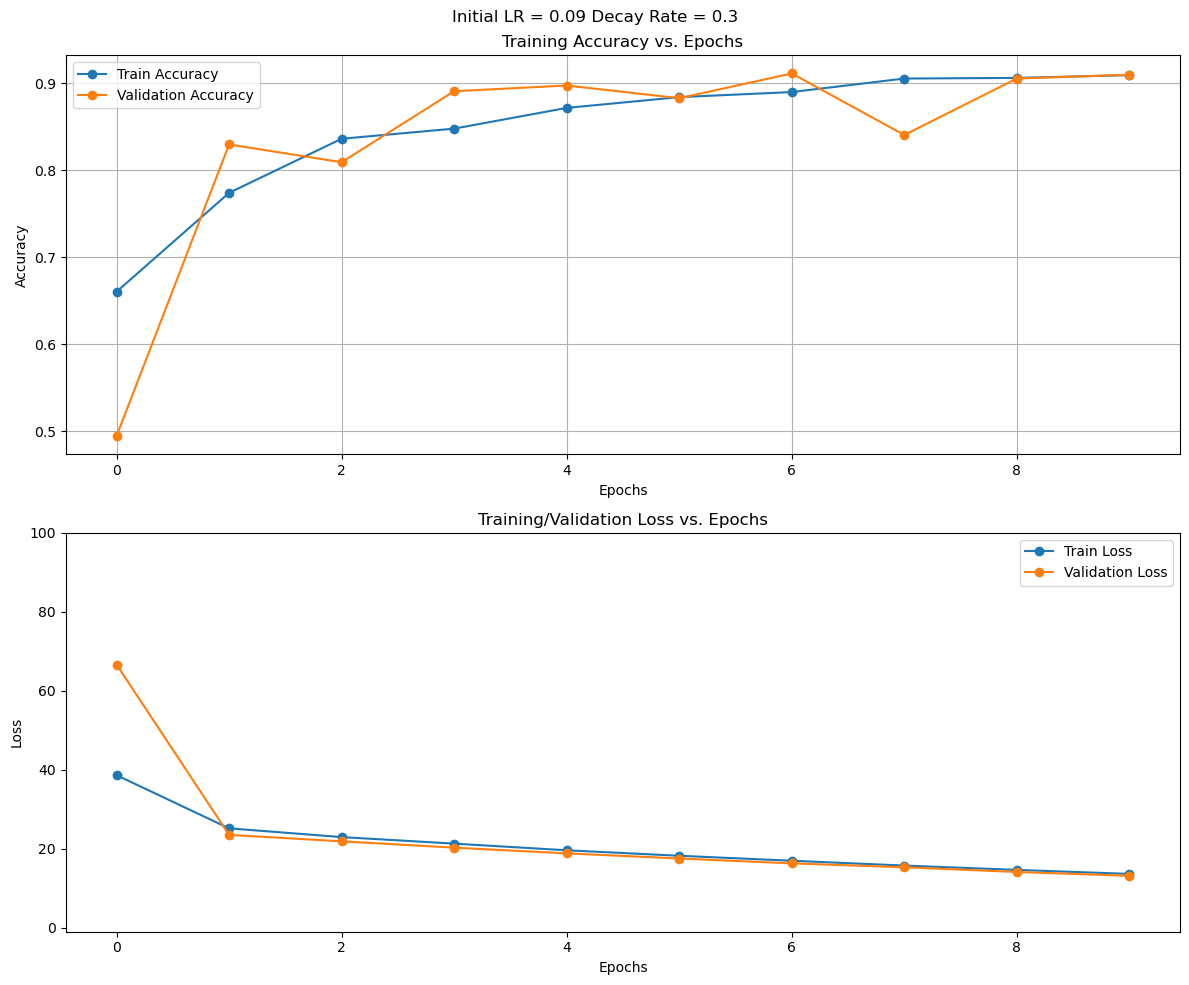

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')
ax[0].grid()

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_ylim([-1, 100])
ax[1].legend(loc='best')

# ax[2].set_title('Learning Rate vs. Epochs')
# ax[2].plot(learning_rate, 'o-', label='Learning Rate')
# ax[2].set_xlabel('Epochs')
# ax[2].set_ylabel('Learning Rate')
# ax[2].legend(loc='best')

# ax[3].set_title('Loss vs learning rate')
# # ax[3].plot(learning_rate, 'o-', label='Learning Rate')
# ax[3].plot(learning_rate, train_loss, 'o-', label='Train Loss')
# ax[3].plot(learning_rate, val_loss, 'o-', label='Validation Loss')
# ax[3].set_ylabel('Loss')
# ax[3].set_xlabel('Learning Rate')
# ax[3].legend(loc='best')

plt.suptitle(f'Initial LR = {init_lr} Decay Rate = {decay_rate}')
plt.tight_layout()
plt.savefig(f'{modelName}-train-report_init-lr={init_lr}_decay-rate={decay_rate}_offrots.png')
plt.show()


# fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
# idx = 0

# for i in range(2):
#     for j in range(5):
#         predicted_label = unique_labels[np.argmax(predictions[idx])]
#         ax[i, j].set_title(f"{predicted_label}", fontsize=10)
#         ax[i, j].imshow(test_generator[idx][0])

#         ax[i, j].axis("off")
#         idx += 1

# # plt.tight_layout()
# plt.suptitle("Test Dataset Predictions", fontsize=20)
# plt.show()


# In[34]:

In [26]:
predictions = cnn_model.predict(test_generator)
# test_loss, test_accuracy = cnn_model.evaluate(validation_generator, batch_size=1) # needs to be divisible
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=1) # needs to be divisible

y_pred = np.argmax(predictions, axis=1)
y_true = testDf_rot['labels'] # this needs to be checked if you change the input dataframes
y_true = y_true.tolist()
# len(y_pred) == len(y_true)
unique_labels = {value: key for key, value in train_generator.class_indices.items()}

# print("Label Mappings for classes present in the training and validation datasets\n")
# for key, value in unique_labels.items():
#     print(f"{key} : {value}")

# function to return key for any value
def get_key(val):
    for key, value in unique_labels.items():
        if val == value:
            return key

    return "key doesn't exist"

Y_true = []
# for i in range(len(y_true)): # This was the original way to do it -- be careful, this only solved a mismatch and could be wrong
for i in range(len(y_pred)):
    Y_true.append(get_key(y_true[i]))

cf_mtx = confusion_matrix(Y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(2, 2)


# cf_mtx.sum()

y_true = np.array([int(x) for x in y_true]) # cast to np array for type consistency with y_pred
errors = (y_true - y_pred != 0) # everywhere the numbers don't match
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

test_images = test_generator.filenames
test_img_err = np.asarray(test_images)[errors]


# fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(12, 10))
# idx = 0

hits = (y_true - y_pred == 0)
y_true_hits = y_true[hits]
y_pred_hits = y_pred[hits]

test_img_hits = np.asarray(test_images)[hits]


1840/1840 [==============================] - 7s 4ms/step - loss: 12.9224 - accuracy: 0.0000e+00


Init conds:
init lr: 0.09, decay rate: 0.3, decay steps: 100000
Test Loss:     12.922381401062012
Test Accuracy: 0.0


C:\Users\Jason\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


              precision    recall  f1-score   support

           0       0.96      0.88      0.92       960
           1       0.88      0.96      0.92       880

    accuracy                           0.92      1840
   macro avg       0.92      0.92      0.92      1840
weighted avg       0.92      0.92      0.92      1840



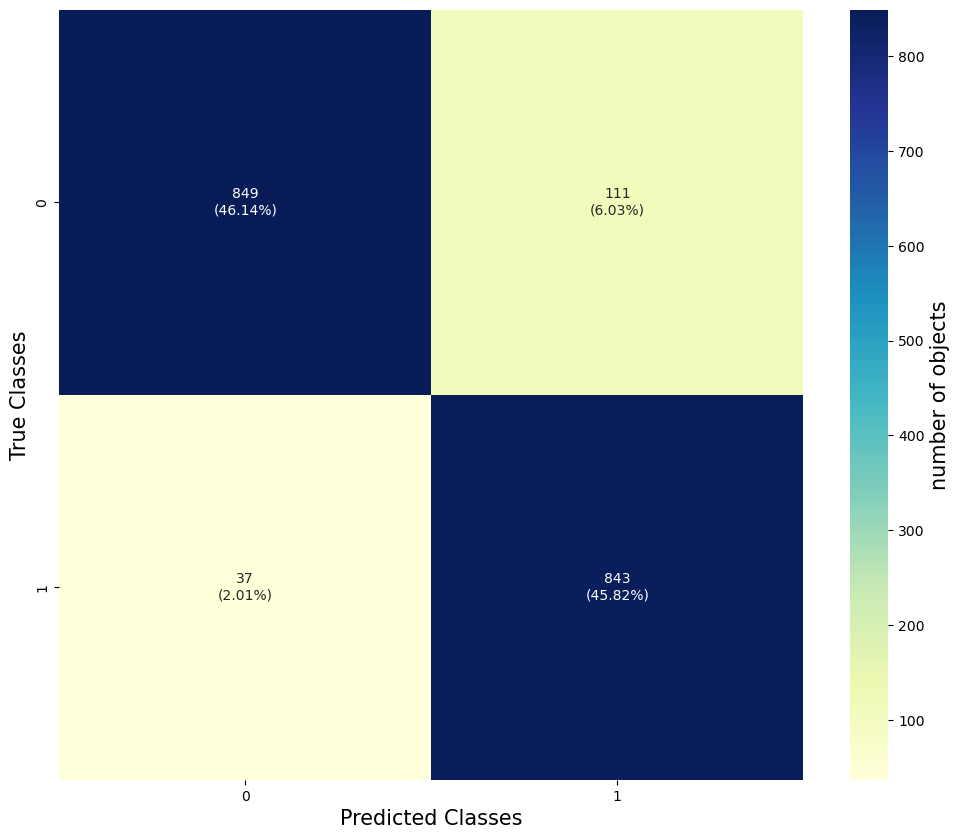

In [48]:
plt.figure(figsize = (12, 10))
# sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(), cmap="YlGnBu", fmt="", annot=box_labels)
ax = sns.heatmap(cf_mtx, cmap="YlGnBu", fmt="", annot=box_labels, cbar_kws={'label': 'number of objects'})
ax.figure.axes[-1].yaxis.label.set_size(15)
plt.xlabel('Predicted Classes', fontsize = 15)
plt.ylabel('True Classes', fontsize = 15)
#plt.show()

# plt.title(f"Test Accuracy: {test_accuracy*100:.2f}")
plt.savefig(f'{modelName}-confusion-matrix_init-lr={init_lr}_decay-rate={decay_rate}.png')

# for i in range(3):
#     for j in range(5):
#         idx = np.random.randint(0, len(test_img_err))
#         true_index = y_true_errors[idx]
#         true_label = unique_labels[true_index]
#         predicted_index = y_pred_errors[idx]
#         predicted_label = unique_labels[predicted_index]
#         ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
#         ax[i, j].imshow(test_generator[idx][0])
#         ax[i, j].axis("off")

# plt.tight_layout()
# plt.suptitle('Wrong Predictions made on test set', fontsize=15)
# plt.show()


# fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(12, 10))
# idx = 0

# for i in range(3):
#     for j in range(5):
#         idx = np.random.randint(0, len(test_img_hits))
#         true_index = y_true_hits[idx]
#         true_label = unique_labels[true_index]
#         predicted_index = y_pred_hits[idx]
#         predicted_label = unique_labels[predicted_index]
#         ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
#         ax[i, j].imshow(test_generator[idx][0])
#         ax[i, j].axis("off")

# plt.tight_layout()
# plt.suptitle('True Predictions made on test set', fontsize=15)
# plt.show()

# # End result:
print(f'Init conds:')
print(f'init lr: {init_lr}, decay rate: {decay_rate}, decay steps: {decay_steps}')
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


## save model weights ## 
cnn_model.save(f'../Models/{modelName}.h5')
print(classification_report(Y_true, y_pred))

In [28]:
# Load the trained model
# model = models.load_model(f'../Models/{modelStr}.h5')
from keras.preprocessing import image

def make_prediction(img_path):
    # Load and preprocess the input image
    # img_path = '../Images/PCC-and-SpecSearch/sdss_ra=48.9999795273873_dec=41.2875102706543-label=0.png'
    img = image.load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.  # Normalize pixel values (assuming your model was trained with normalized inputs)
    
    # Make predictions
    predictions = cnn_model.predict(img_array)
    
    # Postprocess predictions
    predicted_class = np.argmax(predictions)  # Assuming your model outputs class probabilities
    class_labels = ['0', '1']  # Define your class labels accordingly
    predicted_label = class_labels[predicted_class]
    
    # print('Predicted class:', predicted_label)
    return(predicted_label)

trainImgs = os.path.join('..', 'Images', 'PCC-and-SpecSearch', '*.png')

counter = 0
for ind, x in enumerate(glob.glob(trainImgs)):
    if make_prediction(x) != x[-5]:
        counter += 1

print(f'{counter} misses')
len(glob.glob(trainImgs))

44 misses


479

In [29]:
trainObjs = trainObjs.reindex(columns=['labels', 'ra', 'dec'])
trainObjs.to_csv('../Sheets/trainObjectsCrossMatch.csv')

In [30]:
trainObjs

labels         ra        dec
PCC_Bg    3996      0  49.823100  41.407800
          1794      0  49.541100  41.538900
          1591      0  49.509400  41.513500
          2282      0  49.611600  41.197000
          1207      0  49.450800  41.524400
...               ...        ...        ...
Spec_Mems 206       1  50.622746  41.050445
          210       1  50.694593  41.941230
          211       1  49.705849  40.827589
          212       1  49.112658  41.180216
          213       1  49.470275  40.897244

[479 rows x 3 columns]

In [32]:
train_crossMatch = pd.read_csv('../Sheets/trainObjects_filtered_CrossMatched.csv', skiprows = 1)
train_crossMatch


,labels,true_labels,pred_labels,label_diffs,objID,ra,dec,r,r0,g_z0,u_g,g_z,g_r,g_i,r_i,r_z,distance
0,1,1,1,0,1237661059574333557,49.950960,41.547161,14.49405,14.11906,1.101402,0.217379,1.436186,0.775021,0.852034,0.077013,0.661165,2.052572
1,1,1,1,0,1237661059574333557,49.950960,41.547161,14.49405,14.11906,1.101402,0.217379,1.436186,0.775021,0.852034,0.077013,0.661165,2.052572
2,1,1,1,0,1237661059574333557,49.950960,41.547161,14.49405,14.11906,1.101402,0.217379,1.436186,0.775021,0.852034,0.077013,0.661165,2.052572
3,1,1,1,0,1237661059574333557,49.950960,41.547161,14.49405,14.11906,1.101402,0.217379,1.436186,0.775021,0.852034,0.077013,0.661165,2.052572
4,1,1,1,0,1237661059574334576,49.907725,41.472517,22.05002,21.68037,2.257058,-0.048845,2.587074,1.522949,2.158566,0.635616,1.064125,2.999543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,0,0,0,0,1237661055818990429,50.905891,41.366465,17.20432,16.78527,1.720221,1.971970,2.094337,1.089518,1.636820,0.547302,1.004820,44.031249
429,0,0,0,0,1237661083199472188,50.184406,40.800759,16.81091,16.47613,0.636899,1.468370,0.935785,0.586376,0.823126,0.236750,0.349409,44.068734
430,0,0,0,0,1237661121850901163,48.999980,41.287510,16.52428,16.17855,0.611734,1.310324,0.920393,0.572069,0.788336,0.216267,0.348324,44.706460
431,0,0,0,0,1237661059574006457,49.167526,41.982382,16.16910,15.81094,0.514444,1.367605,0.834207,0.534445,0.708618,0.174173,0.299763,44.826075


In [33]:
modelStr

'..\\Models\\pcc_resnet50_10'

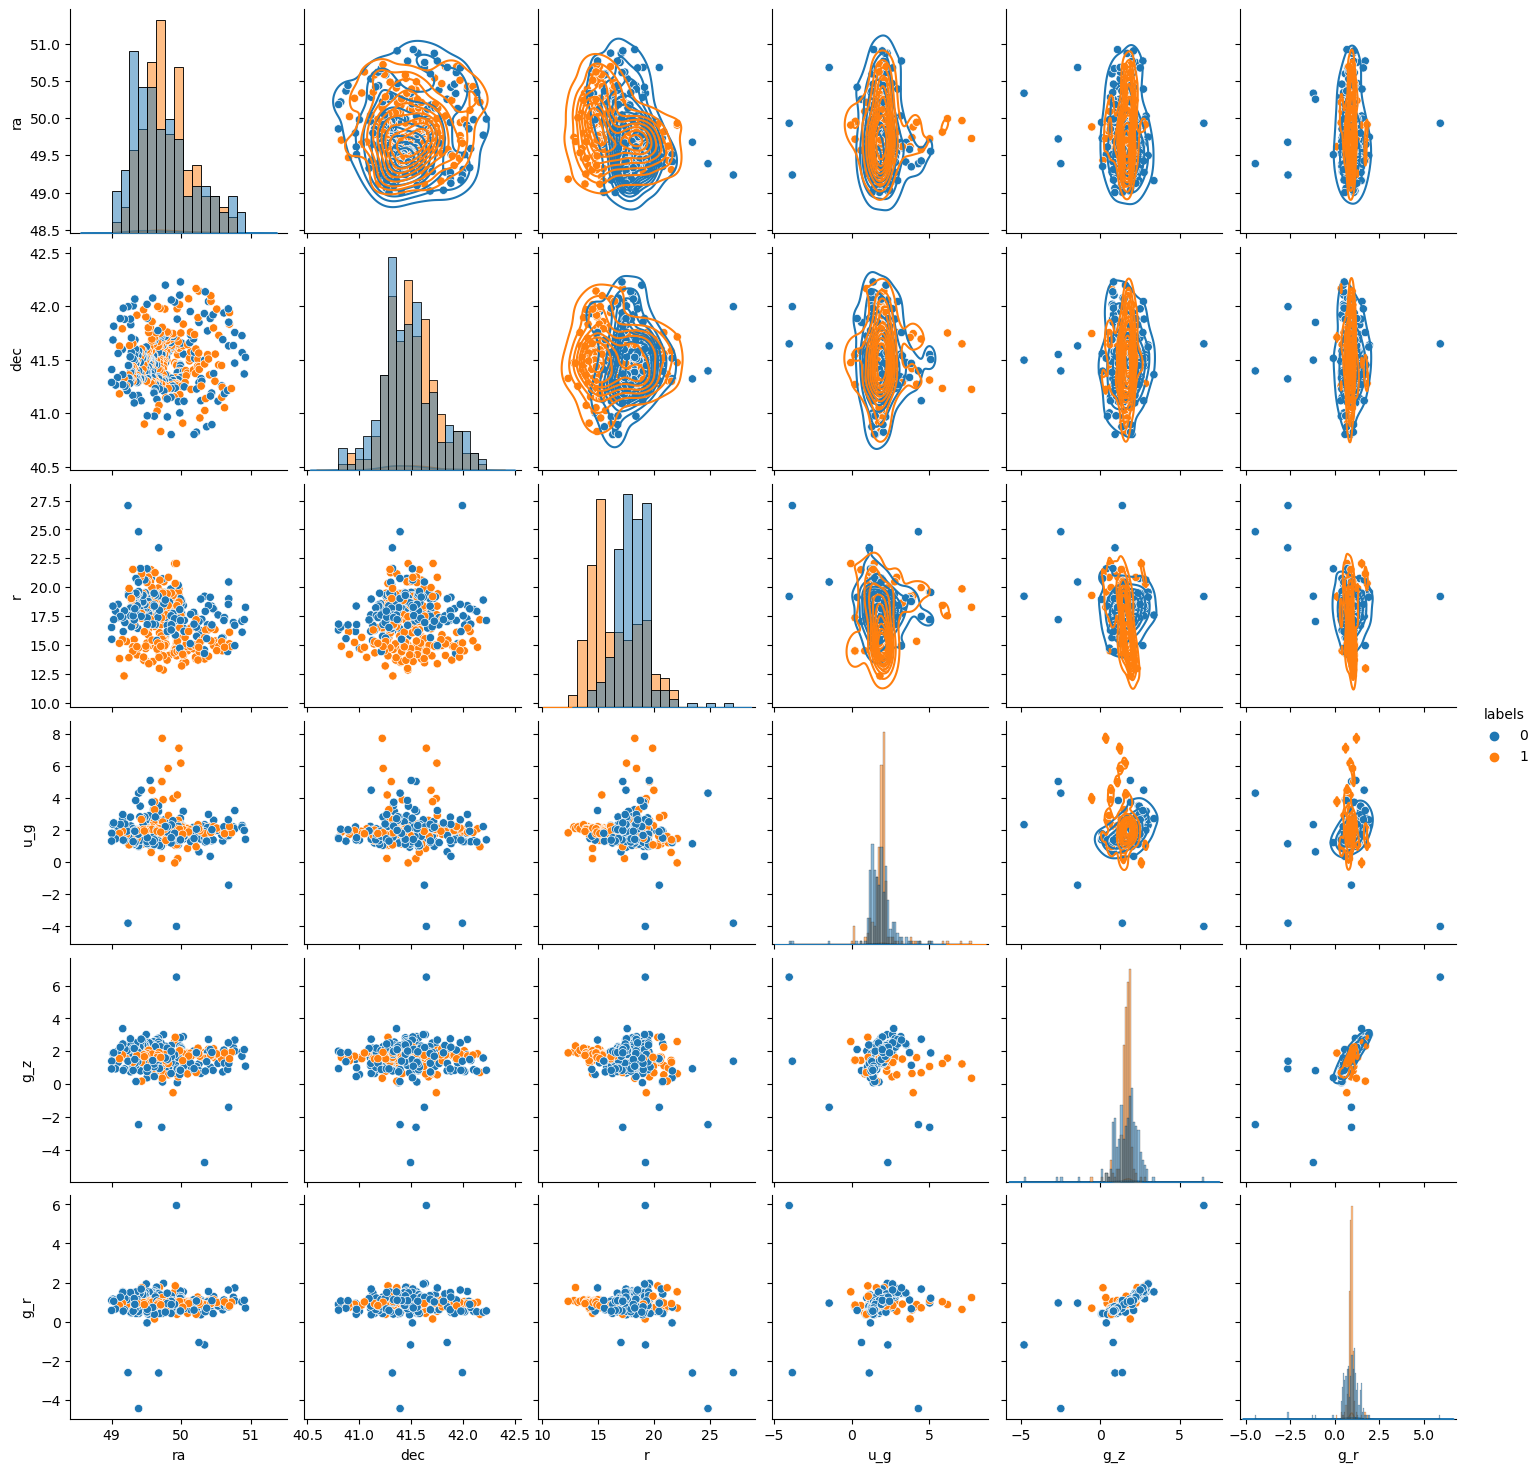

In [34]:
## Uncomment for big pairplot:
pairDf = train_crossMatch[['ra', 'dec', 'r', 'u_g', 'g_z', 'g_r', 'labels']]

p1 = sns.pairplot(pairDf, corner = False, hue = 'labels')
p1.map_diag(sns.histplot)
p1.map_upper(sns.kdeplot)
p1.savefig(f'../Images/{modelName}-classifying-training-set.png')

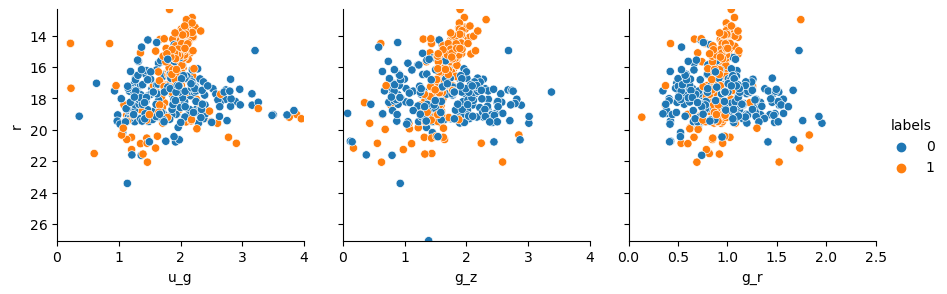

In [35]:
x_vars = pairDf[['u_g', 'g_z', 'g_r']]
y_vars = pairDf[['r']]
y_lim = (y_vars.min()[0], y_vars.max()[0])

f = sns.PairGrid(pairDf, hue="labels", x_vars=x_vars, y_vars=y_vars, height = 3)
# f.map_diag(sns.histplot, color=".3")
f.map_offdiag(sns.scatterplot)
f.add_legend()

## y limits
f.axes[0, 0].set_ylim(y_lim[::-1])

# x limits
f.axes[0, 0].set_xlim((0, 4))
f.axes[0, 1].set_xlim((0, 4))
f.axes[0, 2].set_xlim((0, 2.5))
# f.axes[0, 1].set_xlim(modMagr_lim[::-1])
# f.axes[0, 2].set_xlim(petroRad_r_lim)
f.savefig(f'../Images/{modelName}-Rmag-vs-color.png')


In [36]:
def dra_dec(ra,dec,ra0,dec0) :
	''' calculate angular separation in RA and Dec,
    	given input coords and reference coords,
    	all in radians
	'''
	dra = (np.sin(ra - ra0) * np.cos(dec))
	ddec = -np.cos(ra - ra0) * np.cos(dec) * np.sin(dec0) + np.sin(dec) * np.cos(dec0)
	return np.array([dra, ddec]) # in radians

ra0, dec0 = 49.9506671, 41.5116961 # NGC 1275, from NED

clustCent_R = []
for ra, dec in zip(pairDf['ra'], pairDf['dec']):
    dra, ddec = dra_dec(np.radians(ra), np.radians(dec), np.radians(ra0), np.radians(dec0))
    R_clust = np.sqrt(dra**2+ddec**2) * 75e3
    clustCent_R.append(R_clust)
pairDf['ClusterCentRad'] = clustCent_R

C:\Users\Jason\AppData\Local\Temp\ipykernel_17748\3723318498.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairDf['ClusterCentRad'] = clustCent_R


In [37]:
pairDf


,ra,dec,r,u_g,g_z,g_r,labels,ClusterCentRad
0,49.950960,41.547161,14.49405,0.217379,1.436186,0.775021,1,46.423775
1,49.950960,41.547161,14.49405,0.217379,1.436186,0.775021,1,46.423775
2,49.950960,41.547161,14.49405,0.217379,1.436186,0.775021,1,46.423775
3,49.950960,41.547161,14.49405,0.217379,1.436186,0.775021,1,46.423775
4,49.907725,41.472517,22.05002,-0.048845,2.587074,1.522949,1,66.354771
...,...,...,...,...,...,...,...,...
428,50.905891,41.366465,17.20432,1.971970,2.094337,1.089518,0,956.415905
429,50.184406,40.800759,16.81091,1.468370,0.935785,0.586376,0,958.675980
430,48.999980,41.287510,16.52428,1.310324,0.920393,0.572069,0,978.485916
431,49.167526,41.982382,16.16910,1.367605,0.834207,0.534445,0,982.101080


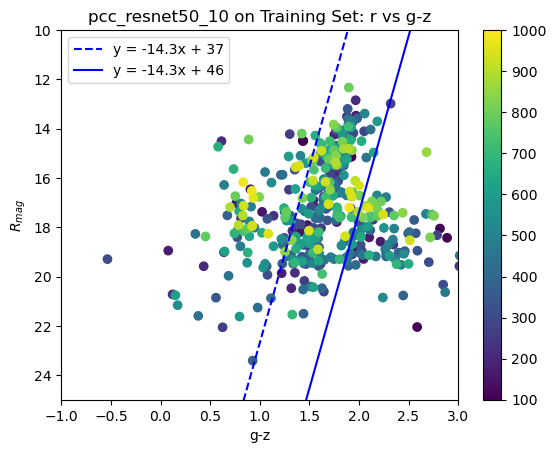

In [38]:
gz_slope = -14.3
gz_intercept1 = 37
gz_intercept2 = 46 # is this one intense enough?

x1 = pairDf['u_g']
x2 = pairDf['g_z']

x3 = pairDf['r']

## TODO -- Get classes on this plot
plt.figure()
xx = np.linspace(-1, 3) 

plt.scatter(x2, x3, c = pairDf['ClusterCentRad'], vmin = 100, vmax = 1000)
plt.plot(xx, xx*gz_slope + gz_intercept1, 'b--', label = f'y = {str(gz_slope)}x + {str(gz_intercept1)}')
plt.plot(xx, xx*gz_slope + gz_intercept2, 'b-', label = f'y = {str(gz_slope)}x + {str(gz_intercept2)}')
plt.ylim([10, 25])
# # plt.xlim(gz_lim)
plt.xlim((-1, 3))
# plt.axvline(x=1.90, color = 'r')
# plt.axvline(x=1.85, color = 'r', label = 'x = 1.85')
# plt.axvline(x=1.30, color = 'r', label = 'x = 1.30')
# plt.axvline(x=1.575, color = 'r', label = 'x = 1.575')
plt.colorbar()
plt.gca().invert_yaxis()
plt.ylabel('$R_{mag}$')
plt.xlabel('g-z')
plt.title(f'{modelName} on Training Set: r vs g-z')
plt.legend()
plt.show()

In [ ]:
blueCloud = pairDf.loc[ (pairDf['r'] > -14.3*pairDf['g_z'] + 46)]
redSequence = pairDf.loc[ (pairDf['r'] > -14.3*pairDf['g_z'] + 37) & (pairDf['r'] < -14.3*pairDf['g_z'] + 46)]
redShoulder = pairDf.loc[ (pairDf['r'] < -14.3*pairDf['g_z'] + 37)]

aug_labels_BlueCloud = ['a' + str(x) for x in blueCloud['labels']]
aug_labels_RedSeq = ['b' + str(x) for x in redSequence['labels']]
aug_labels_RedShould = ['c' + str(x) for x in redShoulder['labels']]

# blueCloud['aug_labels'] = aug_labels_BlueCloud
# redSequence['aug_labels'] = aug_labels_RedSeq
# redShoulder['aug_labels'] = aug_labels_RedShould
pairDf.loc[blueCloud.index, 'aug_labels'] = aug_labels_BlueCloud
pairDf.loc[redSequence.index, 'aug_labels'] = aug_labels_RedSeq
pairDf.loc[redShoulder.index, 'aug_labels'] = aug_labels_RedShould

In [ ]:
pairDf['labels'].value_counts()

In [ ]:
# z = blueCloud['labels'].value_counts()[blueCloud.index[0]]
z = blueCloud['labels'].value_counts()
z

In [ ]:
redSequence['labels'].value_counts()

In [ ]:
redShoulder['labels'].value_counts()